# Zero-index Bound states In the Continuum

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume.minimize import Minimize
from legume.utils import grad_num

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Daisy-hole PhC simulation

In this Notebook, we will have a look at the photonic crystal slab of Minkov et al., PRL 121, 263901 (2018). Curious note: for some reason the abbreviation of bound states in the continuum is BIC and not BSC. Go figure.

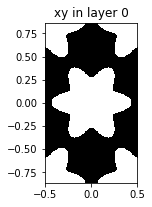

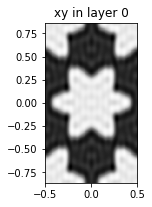

In [81]:
# Define a PhC with a "daisy" hole shape
def daisy_phc(d, r0, rd):
    """
    d: slab thikcness
    r0, rd: radius and radius modulation as defined in the paper
    """
    lattice = legume.Lattice('hexagonal')
    phc = legume.PhotCryst(lattice)
    phc.add_layer(d=d, eps_b=12)

    # We implement the daisy as a FourierShape class
    f_as = np.array([2*r0, 0, 0, 0, 0, 0, rd])
    daisy = legume.FourierShape(x_cent=0, y_cent=0, f_as=f_as)
    phc.add_shape(daisy) 
    return phc

phc = daisy_phc(0.5, 0.35, 0.08)    # parameters of the paper
gme = legume.GuidedModeExp(phc, gmax=5)

# We can have a look at the structure as defined and obtained from an inverse FT
legume.viz.structure(phc, figsize=2., cbar=False, Nx=200, Ny=300)
legume.viz.eps_ft(gme, figsize=2., cbar=False, Nx=200, Ny=300)

Now let's run the simulation and confirm we have the nice Dirac cone + BIC effect at the $\Gamma$-point. Note: for speed, we are running a slightly un-converged simulation. Increasing `gmax = 6` and `gmode_inds = [1, 2, 4]` will reveal a closer degenracy of the bands.

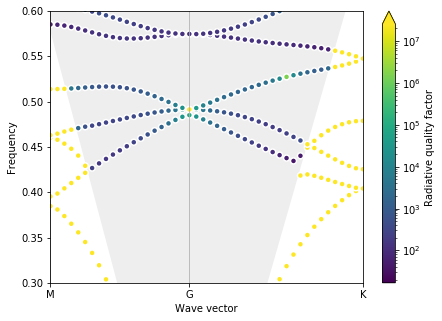

In [82]:
path = lattice.bz_path(['M', 'G', 'K'], [20, 25])
options = {'gmode_inds': [1, 2], 'numeig': 10, 'verbose': False}

gme.run(kpoints=path['kpoints'], **options)

def plot_bands(gme):
    fig, ax = plt.subplots(1, figsize = (7, 5))
    legume.viz.bands(gme, Q=True, ax=ax)
    ax.set_xticks(path['indexes'])
    ax.set_xticklabels(path['labels'])
    ax.xaxis.grid('True')
    ax.set_ylim([0.3,0.6])
    
plot_bands(gme)

## Optimal parameters

The idea of the paper is that these particular modes at $\Gamma$ are guaranteed to be BICs by symmetry. So the only thing that has to be tuned is the accidental degeneracy. When writing the paper, this was done using GME, but tuning the parameters by hand (`legume` did not yet exist). Let's try to use an optimization instead! 

First, let's look at a starting structure with just circular holes.

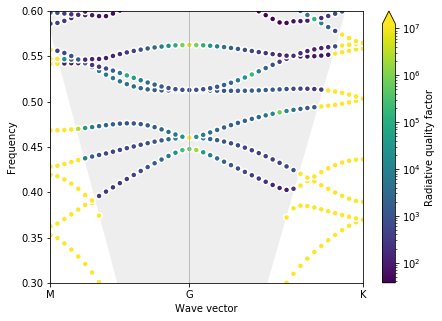

In [87]:
phc = daisy_phc(0.5, 0.3, 0.0)  
gme = legume.GuidedModeExp(phc, gmax=5)
gme.run(kpoints=path['kpoints'], **options)
plot_bands(gme)

Note that we can actually make the degeneracy happen if we decrease the radius. However, the upper band slopes immediately down in the $\Gamma M$ direction, and the Dirac cone is not so "nice".

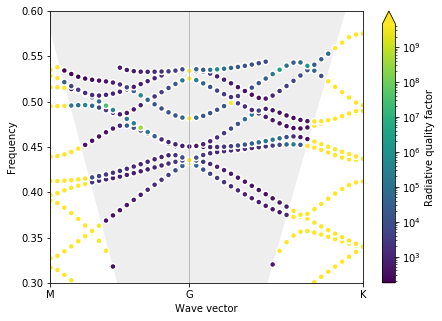

In [88]:
phc = daisy_phc(0.5, 0.15, 0.0)  
gme = legume.GuidedModeExp(phc, gmax=5)
gme.run(kpoints=path['kpoints'], **options)
plot_bands(gme)

## Test gradient

In [92]:
# To compute gradients, we need to set the `legume` backend to 'autograd'
legume.set_backend('autograd')
    
# Objective function is the difference in frequency between modes 1 and 3
# Mode 2 is by symmetry degenerate with either 1 or 3
def of_daisy(params):
    d = params[0]
    r0 = params[1]
    rd = params[2]

    phc = daisy_phc(d, r0, rd)
    gme = legume.GuidedModeExp(phc, gmax=gmax)
    gme.run(kpoints=np.array([[0], [0]]), **options)

    return gme.freqs[0, 3] - gme.freqs[0, 1]

pstart = np.array([0.5, 0.3, 0.])
obj_grad = value_and_grad(of_daisy)

# Compute the autograd gradients (NB: all at once!)
grad_a = obj_grad(pstart)[1]
print("Autograd gradient:   ", grad_a)

# Compute a numerical gradient 
grad_n = grad_num(of_daisy, pstart)
print("Numerical gradient:  ", grad_n)

Autograd gradient:    [-0.0047169   0.05832809 -0.07418007]
Numerical gradient:   [-0.00471684  0.05832819 -0.07418005]


## Optimization of circular holes

In [100]:
np.concatenate((np.array([1, 2]), np.array([3])))

array([1, 2, 3])

In [107]:
def of_d_r(params):
    p_daisy = npa.array(list(params) + [0.])
    return of_daisy(p_daisy)

obj_grad = value_and_grad(of_d_r)

# Initialize an optimization object; jac=True means that obj_grad returns both the value 
# and the jacobian of the objective. The alternative syntax is Minimize(of, jac=grad_of)
opt = Minimize(obj_grad, jac=True)

pstart = npa.array([0.5, 0.3])

# Run an 'adam' optimization
(p_opt, ofs) = opt.adam(pstart, step_size=0.01, Nepochs=20)

Epoch:    1/  20 | Duration:   1.95 secs | Objective: 1.220203e-02
Epoch:    2/  20 | Duration:   1.98 secs | Objective: 1.159231e-02
Epoch:    3/  20 | Duration:   2.01 secs | Objective: 1.102109e-02
Epoch:    4/  20 | Duration:   1.91 secs | Objective: 1.046252e-02
Epoch:    5/  20 | Duration:   1.98 secs | Objective: 9.880346e-03
Epoch:    6/  20 | Duration:   2.02 secs | Objective: 9.244823e-03
Epoch:    7/  20 | Duration:   1.93 secs | Objective: 8.542668e-03
Epoch:    8/  20 | Duration:   1.98 secs | Objective: 7.781859e-03
Epoch:    9/  20 | Duration:   2.03 secs | Objective: 6.990496e-03
Epoch:   10/  20 | Duration:   1.99 secs | Objective: 6.206088e-03
Epoch:   11/  20 | Duration:   1.99 secs | Objective: 5.459241e-03
Epoch:   12/  20 | Duration:   2.01 secs | Objective: 4.763294e-03
Epoch:   13/  20 | Duration:   1.91 secs | Objective: 4.116013e-03
Epoch:   14/  20 | Duration:   1.97 secs | Objective: 3.508565e-03
Epoch:   15/  20 | Duration:   2.03 secs | Objective: 2.933791

In [108]:
print(p_opt)

[0.68402496 0.1106515 ]


Note that the Q increased by almost two orders of magnitude in just 10 steps of the Adam optimization! Let's visuzlize the optimized cavity below.

Cavity quality factor: 460971.43


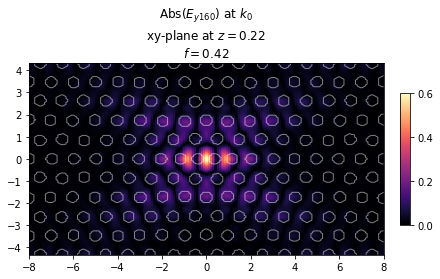

In [10]:
# Optimized parameters
dx = p_opt[0:nc]
dy = p_opt[nc:]

# Run the simulation
(gme, Q) = gme_cavity(dx, dy, gmax=gmax, options=options)
print("Cavity quality factor: %1.2f" %Q)
ax = legume.viz.field(gme, 'e', 0, Nx*Ny, z=dslab/2, component='y', val='abs', N1=200, N2=200)

## Refining the optimization

We note that we used a relatively fast optimization for illustration purposes. In the `legume` paper, we use `gmax = 2.5`, as well as a 3x3 $k$-grid in the Brillouin zone, and average the loss rates. This takes longer time to compute, and significantly more memory if done directly, because all the variables, including all the dense matrices and all the eigenvectors at every $k$ are stored for the backpropagation. However, we provide a way to overcome this extra memory requirement at a low cost of computational time, as shown below.

First, we define a function that computes the loss rates over a specified set of $k$-points.

In [18]:
def gme_cavity_k(params, gmax, options, kpoints):
    dx = params[0:nc]
    dy = params[nc:]
    phc = cavity(dx, dy)
    options['compute_im'] = False
    gme = legume.GuidedModeExp(phc, gmax=gmax)
    gme.run(kpoints=kpoints, **options)
    fims = []
    for ik in range(kpoints[0, :].size):
        (freq_im, _, _) = gme.compute_rad(ik, [Nx*Ny])
        fims.append(freq_im)
    return (gme, npa.array(fims))

We can use this to compute the averaged $Q$ in a straightforward way. Note that it's better to average the loss rates and only then compute the $Q$, rather than average the $Q$-s. 

In [22]:
# Create an nkx x nky grid in k space (positive kx, ky only)
nkx = 3
nky = 3
kx = np.linspace(0, np.pi/Nx, nkx)
ky = np.linspace(0, np.pi/Ny/np.sqrt(3)*2, nky)
kxg, kyg = np.meshgrid(kx, ky)
kxg = kxg.ravel()
kyg = kyg.ravel()

def Q_kavg(params):
    (gme, fims) = gme_cavity_k(params, gmax, options, np.vstack((kxg, kyg)))
    # Note that the real part of the freq doesn't change much so we can just take ik=0 below
    return gme.freqs[0, Nx*Ny]/2/npa.mean(fims)

print("Refined cavity quality factor: %1.2f" %Q_kavg(p_opt))

Refined cavity quality factor: 41541.38


This $Q$-value is three times smaller than what we got above, and is likely closer to the true quality factor. For a converged optimization, it's typically good to average over a small grid in $k$-space as shown here. To use this in an optimization, we can already use `Q_kavg` as an objective function, but, like mentioned above, this will require a lot of memory - specifically, about 9 times more than the original optimization at a single $k$-point. Here is how this can be overcome at a small cost of computational time.

In [20]:
# We set gmax=1 for this example to avoid memory issues
gmax = 1

# Objective function defining the average imaginary part
def fim_kavg(params):
    (gme, fims) = gme_cavity_k(params, gmax, options, np.vstack((kxg, kyg)))
    # Scale for easier printing
    return npa.mean(fims)*1e6

# Compute the gradient and time the computation; print just the first value
obj_grad = value_and_grad(fim_kavg)
t = time.time()
grad_a = obj_grad(pstart)[1]
print("Autograd gradient:  %1.4f, computed in %1.4fs" %(grad_a[0], time.time() - t))

Autograd gradient:  269.5663, computed in 22.0130s


Below is an altenative way to do the same thing; if you compare the memory usage between the cell below and the one above, you'll realize the purpose of this whole thing.

We use a custom function that mimics `map(lambda f: f(params), fns))` in a way that splits the gradient computation instead of storing all the intermediate variables for all functions. NB: the function `fns` all have to return a scalar and `params` are all vectors. `fmap` then returns an array of the same size as the number of functions in `fns`.

In [21]:
from legume.primitives import fmap

def of_kavg_fmap(params):
    # A function factory to make a list of functions for every k-point
    def fim_factory(ik):
        def fim(params):
            (gme, freq_im) = gme_cavity_k(params, gmax, options, np.array([[kxg[ik]], [kyg[ik]]]))
            return freq_im
        return fim
    
    fims = fmap([fim_factory(ik=ik) for ik in range(nkx*nky)], params)
    return npa.mean(fims)*1e6

# Compute the gradient and time the computation; print just the first value
obj_grad = value_and_grad(of_kavg_fmap)
t = time.time()
grad_a = obj_grad(pstart)[1]
print("Autograd gradient:  %1.4f, computed in %1.4fs" %(grad_a[0], time.time() - t))

Autograd gradient:  269.5663, computed in 26.9777s
